## Exploring noise with Fourier

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import itertools
import ot
import glob
import os
import sys
sys.path.append('C:/Users/eriki/OneDrive/Documents/all_folder/Thesis/Thesis/utils')
from utils import *

In [3]:
def create_subplot(ax, data, title, cmap='gray', label='Magnitude'):
    """
    Creates a subplot for a given dataset.

    Parameters:
    - ax: The axes object where the plot will be drawn.
    - data: The data to be displayed in the subplot.
    - title: The title of the subplot.
    - cmap: Colormap used for the plot.
    - label: Label for the colorbar.
    """
    im = ax.imshow(data, cmap=cmap)
    plt.colorbar(im, ax=ax, label=label)
    ax.set_title(title)

In [4]:
dotmark_pictures_path = "..\\..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_index = 1
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
pairs = list(itertools.combinations(image_numbers, 2))

categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = glob.glob(categories_pattern)
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

In [5]:
category_dir = os.path.join(full_path, 'MicroscopyImages')
path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_numbers[image_index]}.png")
im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
im1 = cv2.resize(im1, (resolution, resolution))
im1 = im1 / im1.sum()  # Normalize

# SNR = 10000  # Signal to noise ratio
# noise_param = noise_from_SNR(SNR, signal_power=im1.sum(), res=im1.shape[0])
noise_param = 1e-3  # Sigma for Gaussian noise
noise = np.random.normal(0, noise_param, im1.shape)
im1_noised = im1 + noise
im1_noised = im1_noised / im1_noised.sum()  # Normalize

# Compute the 2D FFT for both the original and noised images
DFT_coefficients_original = np.fft.fft2(im1)
DFT_coefficients_noised = np.fft.fft2(im1_noised)

# Compute the magnitude of the DFT coefficients for visualization
DFT_magnitude_original_abs = np.abs(DFT_coefficients_original)
DFT_magnitude_noised_abs = np.abs(DFT_coefficients_noised)

# Shift the zero frequency component to the center of the spectrum for visualization
DFT_magnitude_shifted_original = np.fft.fftshift(DFT_magnitude_original_abs)
DFT_magnitude_shifted_noised = np.fft.fftshift(DFT_magnitude_noised_abs)

In [6]:
category_names

['CauchyDensity',
 'ClassicImages',
 'GRFmoderate',
 'GRFrough',
 'GRFsmooth',
 'LogGRF',
 'LogitGRF',
 'MicroscopyImages',
 'Shapes',
 'WhiteNoise']

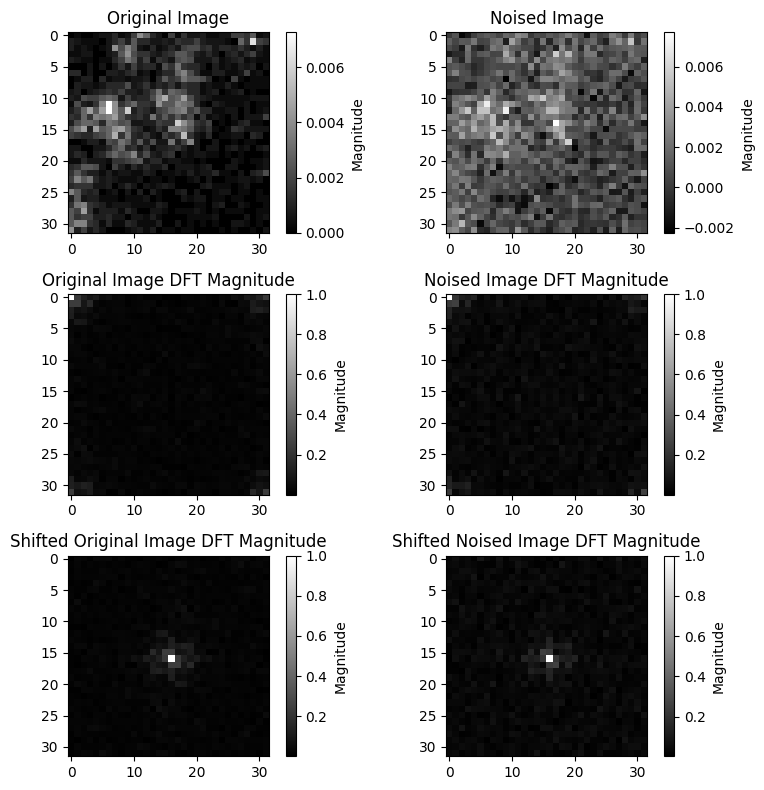

In [7]:
# Plotting
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
create_subplot(axs[0, 0], im1, 'Original Image')
create_subplot(axs[0, 1], im1_noised, 'Noised Image')
create_subplot(axs[1, 0], DFT_magnitude_original_abs, 'Original Image DFT Magnitude')
create_subplot(axs[1, 1], DFT_magnitude_noised_abs, 'Noised Image DFT Magnitude')
create_subplot(axs[2, 0], DFT_magnitude_shifted_original, 'Shifted Original Image DFT Magnitude')
create_subplot(axs[2, 1], DFT_magnitude_shifted_noised, 'Shifted Noised Image DFT Magnitude')
plt.tight_layout()
plt.show()

In [10]:
DFT_magnitude_shifted_noised[16,16]

1.0000000000000002

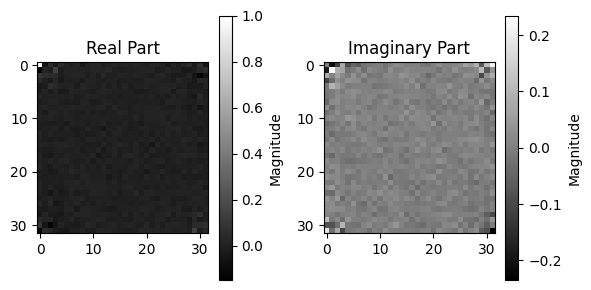

In [10]:
DFT_coefficients_original_real = np.real(DFT_coefficients_original)
DFT_coefficients_original_imag = np.imag(DFT_coefficients_original)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
create_subplot(axs[0], DFT_coefficients_original_real, 'Real Part')
create_subplot(axs[1], DFT_coefficients_original_imag, 'Imaginary Part')
plt.tight_layout()
plt.show()

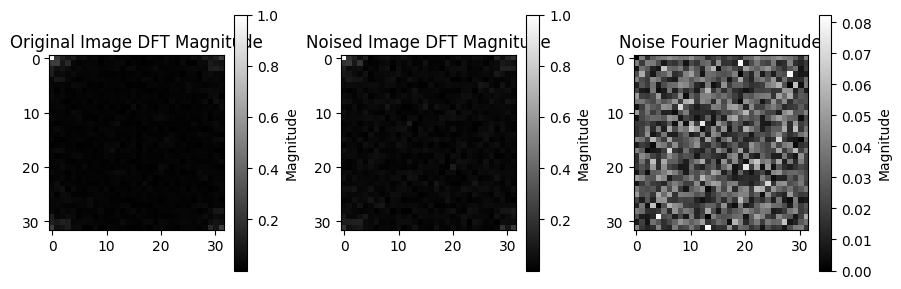

In [11]:
noise_fourier = DFT_coefficients_original - DFT_coefficients_noised

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

create_subplot(axs[0], DFT_magnitude_original_abs, 'Original Image DFT Magnitude')
create_subplot(axs[1], DFT_magnitude_noised_abs, 'Noised Image DFT Magnitude')
create_subplot(axs[2], np.abs(noise_fourier), 'Noise Fourier Magnitude')

plt.tight_layout()
plt.show()

In [12]:
noise_fourier_real = np.real(noise_fourier)
noise_fourier_imag = np.imag(noise_fourier)

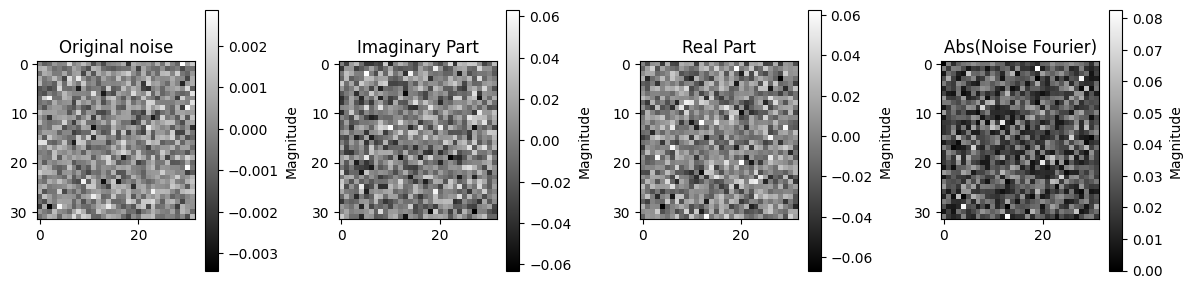

In [13]:
# Plotting
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
create_subplot(axs[0], noise, 'Original noise')
create_subplot(axs[2], noise_fourier_real, 'Real Part')
create_subplot(axs[1], noise_fourier_imag, 'Imaginary Part')
noise_fourier_magnitude = np.abs(noise_fourier)
create_subplot(axs[3], noise_fourier_magnitude, 'Abs(Noise Fourier)')
plt.tight_layout()
plt.show()

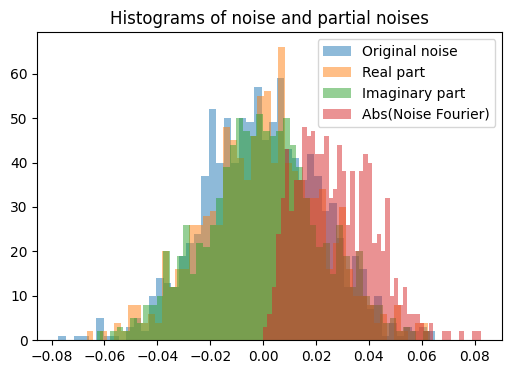

In [14]:
# Plot histrograms for the original noise, and the partial noises in the fourier domain (real and imaginary parts) on the same plot
plt.figure(figsize=(6, 4))
plt.hist(32/np.sqrt(2) * noise.flatten(), bins=50, alpha=0.5, label='Original noise')
plt.hist(noise_fourier_real.flatten(), bins=50, alpha=0.5, label='Real part')
plt.hist(noise_fourier_imag.flatten(), bins=50, alpha=0.5, label='Imaginary part')
plt.hist(noise_fourier_magnitude.flatten(), bins=50, alpha=0.5, label='Abs(Noise Fourier)')
plt.legend()
plt.title('Histograms of noise and partial noises')
plt.show()



In [17]:
print(f'The mean of the original image noise is {np.mean(noise)}')
print(f'The standard deviation of the original image noise is {32 / np.sqrt(2) * np.std(noise)}')
print(f'The real part of the noise has a mean of {np.mean(noise_fourier_real)} \nand a standard deviation of {np.std(noise_fourier_real)}')
print(f'The imaginary part of the noise has a mean of {np.mean(noise_fourier_imag)} \nand a standard deviation of {np.std(noise_fourier_imag)}')
print(f'The magnitude of the noise in the Fourier domain has a mean of {np.mean(noise_fourier_magnitude)} \nand a standard deviation of {np.std(noise_fourier_magnitude)}')

The mean of the original image noise is -1.7630519889070317e-06
The standard deviation of the original image noise is 0.021954155809774206
The real part of the noise has a mean of 7.273463799728158e-05 
and a standard deviation of 0.022065410000374527
The imaginary part of the noise has a mean of 0.0 
and a standard deviation of 0.021918694738066163
The magnitude of the noise in the Fourier domain has a mean of 0.027467515831234066 
and a standard deviation of 0.014589460644370236


### Going over all the images

In [ ]:
means_mean = []
means_std = []
stds_mean = []
stds_std = []
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
num_experiments = 5000
noise_param = 1e-2

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image in image_numbers:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        
        noise = np.random.normal(0, noise_param, im1.shape)
        im1_noised = im1 + noise

        delta_means = []
        delta_stds = []

        for i in range(num_experiments):
            # Compute the 2D FFT for both the original and noised images
            DFT_coefficients_original = np.fft.fft2(im1)
            DFT_coefficients_noised = np.fft.fft2(im1_noised)
            # Compute the magnitude of the DFT coefficients for visualization
            DFT_magnitude_original = np.abs(DFT_coefficients_original)
            DFT_magnitude_noised = np.abs(DFT_coefficients_noised)
            # Shift the zero frequency component to the center of the spectrum for visualization
            DFT_magnitude_shifted_original = np.fft.fftshift(DFT_magnitude_original)
            DFT_magnitude_shifted_noised = np.fft.fftshift(DFT_magnitude_noised)

            deltas = DFT_magnitude_original - DFT_magnitude_noised
            delta_means.append(np.mean(deltas))
            delta_stds.append(np.std(deltas))

        delta_means_mean = np.mean(delta_means)
        delta_means_std = np.std(delta_means)

        delta_stds_mean = np.mean(delta_stds)
        delta_stds_std = np.std(delta_stds)

        means_mean.append(delta_means_mean)
        means_std.append(delta_means_std)
        stds_mean.append(delta_stds_mean)
        stds_std.append(delta_stds_std)
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

In [ ]:
plt.hist(means_mean, alpha=0.5, label='Means', color='blue')
plt.hist(stds_mean, alpha=0.5, label='Stds', color='red')
plt.legend()
plt.title('Means Histogram')
plt.show()

In [ ]:
plt.hist(means_std, bins=100, alpha=0.5, label='Means', color='blue')
plt.hist(stds_std, bins=100, alpha=0.5, label='Stds', color='red')
plt.legend()
plt.title('Stds Histogram')
plt.show()

In [ ]:
# Determine the overall range for all categories
all_values = np.concatenate([means_mean[i*10:(i+1)*10] for i in range(10)])
min_value = all_values.min()
max_value = all_values.max()

# Define common bins within the overall range
bins = np.linspace(min_value, max_value, 20) # Adjust the number 20 as needed

for i in range(10):
    start = i * 10
    end = (i + 1) * 10
    plt.hist(means_mean[start:end], bins=bins, color=colors[i], alpha=0.5, label=f'{category_names[i]}')

plt.xlabel('$\delta_{k}$')
plt.ylabel('Number of images')
plt.legend()
plt.title('Mean value of $\delta_{k}$')
plt.show()

In [ ]:
# Determine the overall range for all categories
all_values = np.concatenate([means_mean[i*10:(i+1)*10] for i in range(10)])
min_value = all_values.min()
max_value = all_values.max()

# Define common bins within the overall range
bins = np.linspace(min_value, max_value, 20) # Adjust the number 20 as needed
category_means = [np.mean(means_mean[i*10:(i+1)*10]) for i in range(10)]

for i, (mean, name) in enumerate(zip(category_means, category_names)):
    plt.scatter(i, mean, color=colors[i])  # Assume colors is defined
    plt.text(i, mean, f' {name}', va='center', ha='left', fontsize=8)

plt.xlabel('$\delta_{k}$')
plt.ylabel('Mean value')
plt.title('Mean value of $\delta_{k}$ by Category')
plt.xticks(range(len(category_names)), [])  # Hide x-axis labels if desired
plt.show()